# Imports

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

C:\Users\Artur\AppData\Local\Continuum\anaconda3\lib\site-packages\fastbook\__init__.py:22: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


# Collecting Data

## Bing Search Queries

In [2]:
#Microsoft Bing Search, 1000 queries per month and 150 per query 
key = os.environ.get('AZURE_SEARCH_KEY', 'a375a849abca42528173e00abf19ce16')

Run this to search up your search term and get 150 Image URLs saved into images as a list
```
results = search_images_bing(key, 'search term') #Search for 150 results and store into Results
images = results.attrgot('content_url') #Get the Image URLs from results
```

In [3]:
#Declare categories here
categories = 'grizzly','black','teddy' #Labels
group = 'bear'

In [4]:
path = Path(group) #Folder
if not path.exists(): #Create folder if it doesn't exist yet, 
    path.mkdir()
    for o in categories: #In if statement so doesn't overlap and repeat
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} {group}') #Can pass min_sz to get minimum size of images
        download_images(dest, urls=results.attrgot('content_url'))
    print("Done")

## Cleaning Data

In [5]:
fns = get_image_files(path)
fns

(#423) [Path('bear/black/00000000.jpg'),Path('bear/black/00000001.jpg'),Path('bear/black/00000002.jpg'),Path('bear/black/00000003.jpg'),Path('bear/black/00000004.jpg'),Path('bear/black/00000005.jpg'),Path('bear/black/00000006.jpg'),Path('bear/black/00000007.jpg'),Path('bear/black/00000008.jpg'),Path('bear/black/00000009.jpg')...]

In [6]:
#Check for corrupt images and unlink them
failed = verify_images(fns)
failed.map(Path.unlink);

# Setting Up Data

## Creating DataBlock

In [7]:
#DataBlock?

In [8]:
#Create a DataLoader object that fastai uses to store training and validation set data. Template for DataLoader
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #Tuple for what kind of independent and dependent we have
    get_items=get_image_files, #Takes it from path, by default
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #RandomSplitter splits it randomly, 20% with seed
    get_y=parent_label, #Parent label means use folder names as labels
    item_tfms=Resize(224)) #Makes them all the same sizee

In [9]:
#DataBlock.dataloaders?

In [10]:
#This gets run so that you can actually pass data into it. If you want to adjust parameters, change DataBlock
dls = data_block.dataloaders(path, num_workers = 0) #Set num_workers = 0 if Windows, cannot do multiprocessign

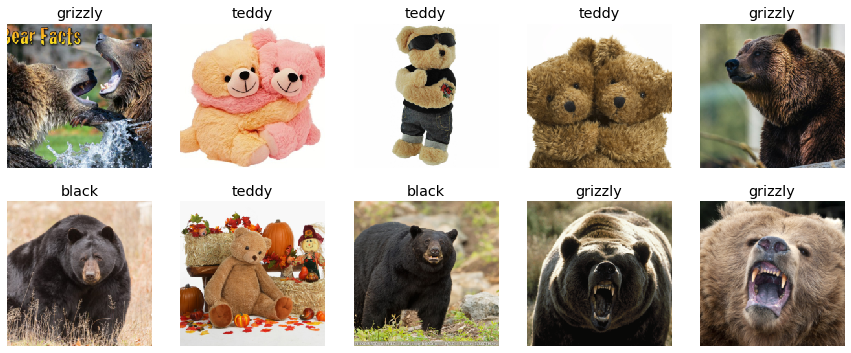

In [11]:
dls.valid.show_batch(max_n=10, nrows=2)

A convenient tool to update your DataBlock with new data is:
```
data_block = data_block.new(item_tfms= RandomResizedCrop(224, min_scale=0.3))
```

Other options for item_tfms are:
```
#Squishes to make fit
data_block = data_block.new(item_tfms=Resize(224, ResizeMethod.Squish))

#Adds black padding to make fit
data_block = data_block.new(item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros')) 
```

This has the benefit of keeping everything else the same while only updating that one aspect

In [12]:
#RandomResizedCrop means that you randomly select different parts of the image to crop at a time, data augmentation
data_block = data_block.new(item_tfms= RandomResizedCrop(224, min_scale= 0.3)) #min_scale: min amount of image to keep

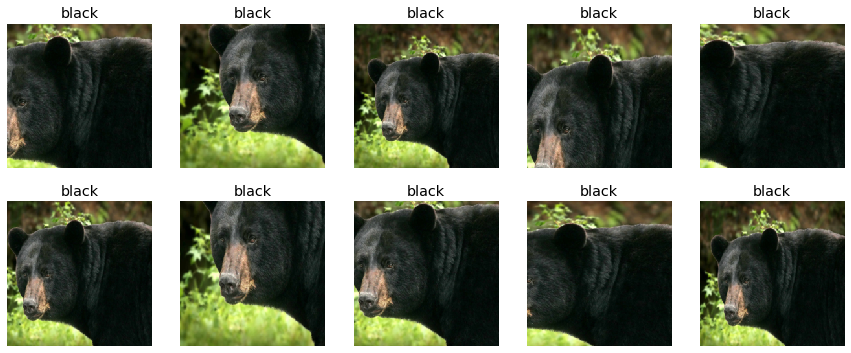

In [13]:
dls = data_block.dataloaders(path, num_workers = 0) #Set num_workers = 0 if Windows, cannot do multiprocessign
dls.train.show_batch(max_n=10, nrows=2, unique=True) #unique = True means show the data augmentation of one image

## Data Augmentation

In [14]:
#batch_tfms use thes GPU to apply transformations, aug_transforms() is the works (rot, flip, warp, bright, contrast)
data_block = data_block.new(item_tfms=RandomResizedCrop(224, min_scale= 0.3), batch_tfms=aug_transforms(mult = 1))

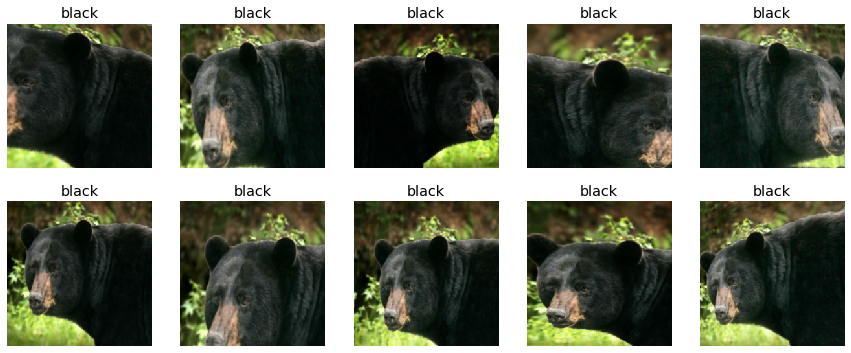

In [15]:
dls = data_block.dataloaders(path, num_workers = 0) #Set num_workers = 0 if Windows, cannot do multiprocessign
dls.train.show_batch(max_n=10, nrows=2, unique=True) #unique = True means show the data augmentation of one image

# Train the model

## Learning

In [16]:
#cnn_learner?

In [17]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [18]:
learn.fine_tune(4) #Fine-tune focuses training on later layers to not throw away, best for pretrained

epoch,train_loss,valid_loss,accuracy,time
0,1.544426,0.066422,0.988095,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.174072,0.017283,1.000000,00:31
1,0.123722,0.018826,0.988095,00:31
2,0.101699,0.023456,0.988095,00:31
3,0.082413,0.017359,0.988095,00:31


## Interpreting

Use a confusion matrix to see where in the validation set most of your mistakes lie

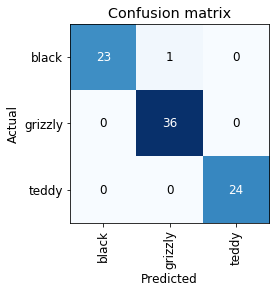

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()#See which ones it was getting wrong in comparison to others

Plot the top losses so you can see which ones it got the most wrong (highest confidence in wrong answer) or which ones it got lucky (lowest confidence in right answer)|

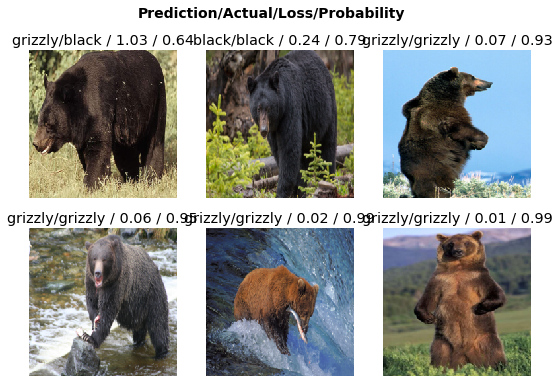

In [20]:
interp.plot_top_losses(6, nrows=2)

## Cleaning

Go into data and either remove or relabel based on category

In [21]:
cleaner = ImageClassifierCleaner(learn)
#cleaner

In [22]:
#This deletes data marked for deletion
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [23]:
#This relabels the categories 
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Exporting

To export your architecture and your model as a .pkl file

In [24]:
learn.export()

In [25]:
path.ls(file_exts='.pkl')

(#0) []

In [26]:
#Load the inference from the export.pkl file
learn_inf = load_learner('export.pkl')

In [27]:
learn_inf.predict('test/0.jpg')

('teddy', tensor(2), tensor([0.0113, 0.0111, 0.9776]))

In [28]:
learn_inf.predict('test/0.jpg')[0]

'teddy'

# Deployment

## Using Widgets

We're going to use Viola to deploy our model

In [52]:
#This is the function that runs 
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')
btn_upload = widgets.FileUpload()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl = widgets.Output()
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred = widgets.Label()
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify) #Pass on_click_classify function to the on_click of our button

In [53]:
#hide_output
#VBox puts it all together in an array of buttons, labels, etc
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Deploying using Viola

In [47]:
#hide
!pip install voila
!jupyter serverextension enable voila —sys-prefix

  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

spyder 3.3.3 requires pyqt5<=5.12; python_version >= "3", which is not installed.
nbdev 1.0.18 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: C:\Users\Artur\.jupyter
    - Validating...
      voila 0.2.4 ok
Enabling: —sys-prefix
- Writing config: C:\Users\Artur\.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?


In [31]:
#https://mybinder.org/v2/gh/finnisvanilla/bear_viola_test/master?urlpath=%2Fviola%2Frender%2Fbear_viola.ipynb